In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import os
cur_path = "/content/drive/MyDrive/BDB 2024/"
os.chdir(cur_path)
!pwd

Mounted at /content/drive
/content/drive/MyDrive/BDB 2024


In [2]:
!pip install pyspark

# The entry point to programming Spark with the DataFrame API.
from pyspark.sql import SparkSession

spark = SparkSession.builder.master("local[4]").appName("DataFrame").getOrCreate()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 3.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425345 sha256=99362475023a0c2082494e97b09de3353c28a2b57beac35be736a8e8f3cd7d0f
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [3]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 1000)

from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.window import Window
from pyspark.sql.functions import sqrt

import matplotlib.pyplot as plt

In [199]:
# results = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/predictions.csv')
# tracking = pd.read_csv('C:/Users/19012/Documents/BDB 2024/data_for_model.csv').head()
# tackles = pd.read_csv('C:/Users/19012/Documents/BDB 2024/nfl-big-data-bowl-2024/tackles.csv')
players = pd.read_csv('./nfl-big-data-bowl-2024/players.csv')
plays = pd.read_csv('./nfl-big-data-bowl-2024/plays.csv')

results = spark.read.option("header",'True').parquet("./predictions.parquet")
tracking = spark.read.parquet("./data_for_model.parquet")
tackles = spark.read.option("header",'True').csv('./nfl-big-data-bowl-2024/tackles.csv')
# players = spark.read.option("header",'True').csv('./nfl-big-data-bowl-2024/players.csv')

In [5]:
results.show(5)

+----------+------+-------+-----+-----+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------------+---------+------------------+-------------------+------------------+--------------------+--------------------+-------------+------------------+-------------------+------------------+------------+----------+--------------------+-----+-----------------------+
|    gameId|playId|frameId|nflId|X_std|              Y_std|            dir_std|                  s|                  a|               o_std|      X_std_carrier|      Y_std_carrier|s_carrier|   dir_std_carrier|          a_carrier|     o_std_carrier|     dist_to_carrier|     dist_to_blocker|pursuit_angle|              down|          yardsToGo|    yardlineNumber|gameId_games|week_games|            features|label|predicted_pursuit_angle|
+----------+------+-------+-----+-----+-------------------+-------------------+-------------------+-------------------+-----

In [6]:
tracking.show(5)

+----------+------+-------+-----+------------------+------------------+------------------+----+----+------+------------------+------------------+---------+---------------+---------+-----------------+------------------+------------------+------------------+----+---------+--------------+
|    gameId|playId|frameId|nflId|             X_std|             Y_std|           dir_std|   s|   a| o_std|     X_std_carrier|     Y_std_carrier|s_carrier|dir_std_carrier|a_carrier|    o_std_carrier|   dist_to_carrier|   dist_to_blocker|     pursuit_angle|down|yardsToGo|yardlineNumber|
+----------+------+-------+-----+------------------+------------------+------------------+----+----+------+------------------+------------------+---------+---------------+---------+-----------------+------------------+------------------+------------------+----+---------+--------------+
|2022090800|   101|     10|43335|48.629999999999995|21.513333333333335|213.79000000000002|0.27| 1.4|-84.95|40.400000000000006|23.7433333333

In [ ]:
tackles.show(5)

+----------+------+-----+------+------+------------+----------------+
|    gameId|playId|nflId|tackle|assist|forcedFumble|pff_missedTackle|
+----------+------+-----+------+------+------------+----------------+
|2022090800|   101|42816|     1|     0|           0|               0|
|2022090800|   393|46232|     1|     0|           0|               0|
|2022090800|   486|40166|     1|     0|           0|               0|
|2022090800|   646|47939|     1|     0|           0|               0|
|2022090800|   818|40107|     1|     0|           0|               0|
+----------+------+-----+------+------+------------+----------------+
only showing top 5 rows



In [ ]:
players.head()

,nflId,height,weight,birthDate,collegeName,position,displayName
0,25511,6-4,225,1977-08-03,Michigan,QB,Tom Brady
1,29550,6-4,328,1982-01-22,Arkansas,T,Jason Peters
2,29851,6-2,225,1983-12-02,California,QB,Aaron Rodgers
3,30842,6-6,267,1984-05-19,UCLA,TE,Marcedes Lewis
4,33084,6-4,217,1985-05-17,Boston College,QB,Matt Ryan


# OPA vs Pursuit Angle

Calculate the absoulte difference between OPA and Pursuit Angle. We can then use this to measure performance.

In [200]:
results = results.withColumn( 'abs_diff', abs(results['pursuit_angle'] - results['predicted_pursuit_angle']))
results.show(5)

+----------+------+-----+-------+-----+-------------------+-------------------+-------------------+-------------------+--------------------+-------------------+-------------+---------+------------------+-------------------+------------------+--------------------+--------------------+-------------+------------------+-------------------+------------------+--------+----------------+-----------------+------------+----------+------------------------+--------------------+----------------+---------------+--------------------+-----------------------+-------------------+
|    gameId|playId|nflId|frameId|X_std|              Y_std|            dir_std|                  s|                  a|               o_std|      X_std_carrier|Y_std_carrier|s_carrier|   dir_std_carrier|          a_carrier|     o_std_carrier|     dist_to_carrier|     dist_to_blocker|pursuit_angle|              down|          yardsToGo|    yardlineNumber|position|offenseFormation|defendersInTheBox|gameId_games|week_games|offense

In [201]:
avg_abs_diff = results.groupby('nflId').agg({'abs_diff': 'mean'}).withColumnRenamed("avg(abs_diff)", 'avg_abs_diff')
avg_abs_diff.show(5)

+-----+------------------+
|nflId|      avg_abs_diff|
+-----+------------------+
|45011|13.419066670644414|
|43302|14.073158318157388|
|53565| 17.66203119024516|
|46521|11.430440249692325|
|44906|18.905397921549458|
+-----+------------------+
only showing top 5 rows



In [202]:
# tot_tackles = tackles[['nflId','tackle']].groupby(by='nflId').sum().reset_index()
tot_tackles = tackles.groupby('nflId').agg({'tackle': 'sum'}).withColumnRenamed("sum(tackle)", 'total_tackles')
tot_tackles.show(5)

+-----+-------------+
|nflId|total_tackles|
+-----+-------------+
|47984|         17.0|
|52991|         20.0|
|47940|          2.0|
|52571|         20.0|
|47877|         27.0|
+-----+-------------+
only showing top 5 rows



In [203]:
pa_tackles = avg_abs_diff.join(tot_tackles, on='nflId')
pa_tackles.show(5)

+-----+------------------+-------------+
|nflId|      avg_abs_diff|total_tackles|
+-----+------------------+-------------+
|45011|13.419066670644414|         14.0|
|53565| 17.66203119024516|         26.0|
|46521|11.430440249692325|         14.0|
|44906|18.905397921549458|         19.0|
|52697|23.168341703896104|         12.0|
+-----+------------------+-------------+
only showing top 5 rows



# Correlation Tackle and OPA Diff

Show the correlation between total tackles and average OPA Diff.

In [150]:
pa_tackles = pa_tackles.toPandas()
pa_tackles.head()

,nflId,avg_abs_diff,total_tackles
0,45011,13.419067,14.0
1,53565,17.662031,26.0
2,46521,11.430440,14.0
3,44906,18.905398,19.0
4,52697,23.168342,12.0


In [ ]:
pa_tackles.shape

(551, 3)

In [ ]:
print(pa_tackles.total_tackles.min())
print(pa_tackles.total_tackles.max())

0.0
61.0


In [151]:
pa_tackles = pa_tackles[pa_tackles['total_tackles']>20]

In [152]:
league_avg_mad = pa_tackles.avg_abs_diff.mean()
league_avg_mad_tackles = pa_tackles.total_tackles.mean()

-0.32143692213656533


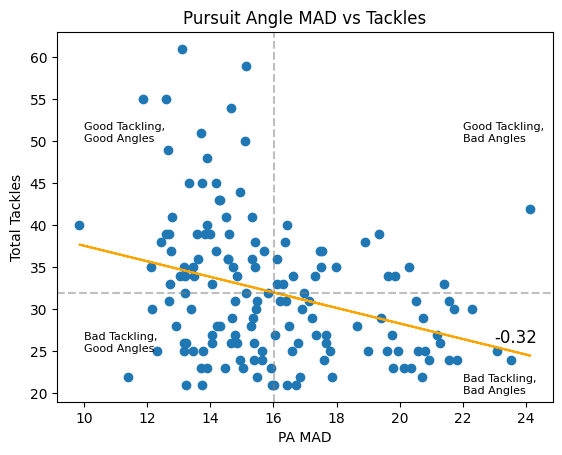

In [153]:
print(pa_tackles.corr()['avg_abs_diff'][2])
correlation = pa_tackles.corr()['avg_abs_diff'][2].round(2)
# correlation = round(correlation,2)
plt.scatter(x=pa_tackles['avg_abs_diff'], y=pa_tackles['total_tackles'])
#obtain m (slope) and b(intercept) of linear regression line
x = pa_tackles['avg_abs_diff']
y = pa_tackles['total_tackles']
m, b = np.polyfit(x, y, 1)

#add linear regression line to scatterplot
plt.plot(x, m*x+b, color='orange')

plt.axvline(x=league_avg_mad,color='grey',alpha=0.5,linestyle ="--")
plt.axhline(y=league_avg_mad_tackles,color='grey',alpha=0.5,linestyle ="--")

plt.text(23, 26, correlation, fontsize = 12)
plt.text(10, 50, 'Good Tackling,\nGood Angles', fontsize = 8)
plt.text(10, 25, 'Bad Tackling,\nGood Angles', fontsize = 8)
plt.text(22, 50, 'Good Tackling,\nBad Angles', fontsize = 8)
plt.text(22, 20, 'Bad Tackling,\nBad Angles', fontsize = 8)

plt.title( 'Pursuit Angle MAD vs Tackles' )
plt.xlabel('PA MAD')
plt.ylabel('Total Tackles')
plt.savefig('./madtackles.png')

# Table with OPA Diff

If the metric predicts well, then create a table sorted by OPA Diff to see who the good tacklers are.

In [154]:
pa_tackles = pa_tackles.merge(players[['nflId','displayName']],
                 how='left',
                 on=['nflId'])

In [155]:
# plotting functions
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i+2], 16) for i in range(1,6,2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1))/255
    c2_rgb = np.array(hex_to_RGB(c2))/255
    mix_pcts = [x/(n-1) for x in range(n)]
    rgb_colors = [((1-mix)*c1_rgb + (mix*c2_rgb)) for mix in mix_pcts]
    #return ["#" + "".join([format(int(val,round(2)*255), "02x") for val in item]) for item in rgb_colors]
    return ["#" + "".join([format(int(val.round(2)*255), "02x") for val in item]) for item in rgb_colors]

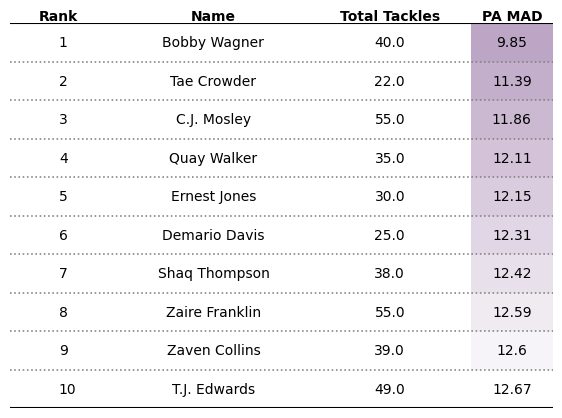

In [177]:
fig = plt.figure(figsize=(7,5))
ax = plt.subplot()
# final_df['total_xPress'] = round(final_df['total_xPress'],2)
# plotting_df = pa_tackles[pa_tackles['snaps']>100].sort_values(by='total_xPress')[['displayName',
#                                                                                 'officialPosition',
#                                                                                 'total_press',
#                                                                                 'total_xPress',
#                                                                                'pff_sack']].tail(10).reset_index()
pa_tackles['avg_abs_diff'] = pa_tackles['avg_abs_diff'].round(2)
plotting_df = pa_tackles.sort_values(by='avg_abs_diff', ascending=False)[['displayName',
                                                                     'total_tackles',
                                                                     'avg_abs_diff']].tail(10).reset_index().reset_index().rename(columns={'level_0':'Rank'})
plotting_df['Rank'] = 10-plotting_df['Rank']

color1 = '#FFFFFF'
color2 = '#7C4D8B'

plotting_df['colors'] = get_color_gradient(color1, color2, len(plotting_df))

ncols = 4
nrows = plotting_df.shape[0]

ax.set_xlim(0, 2)
ax.set_ylim(0, nrows)

positions = [0.18, 0.75, 1.4, 1.85]#, 4.35]
columns = ['Rank','displayName','total_tackles','avg_abs_diff']

# Add table's main text
for i in range(nrows):
    for j, column in enumerate(columns):
        if j == 0:
            ha = 'left'
        else:
            ha = 'center'
        if column == 'abs_diff':
            text_label = f'{plotting_df[column].iloc[i]:,.2f}'
            weight = 'bold'
        else:
            text_label = f'{plotting_df[column].iloc[i]}'
            weight = 'normal'
        ax.annotate(
            xy=(positions[j], i+0.5),
            text=text_label,
            ha=ha,
            va='center',
            weight=weight
        )
# Add column names
column_names = ['Rank','Name','Total Tackles','PA MAD']
for index, c in enumerate(column_names):
        if index == 0:
            ha = 'center'
        else:
            ha = 'center'
        ax.annotate(
            xy=(positions[index], nrows),
            text=column_names[index],
            ha=ha,
            va='bottom',
            weight='bold'
        )

# Add dividing lines
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [nrows, nrows], lw=1.5, color='black', marker='', zorder=4)
ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [0, 0], lw=1.5, color='black', marker='', zorder=4)
for x in range(1, nrows):
    ax.plot([ax.get_xlim()[0], ax.get_xlim()[1]], [x, x], lw=1.15, color='gray', ls=':', zorder=3 , marker='')

for i in range(1,nrows+1):
    ax.fill_between(
        x=[1.7,2.25],
        y1=i,
        y2=i-1,
        color=plotting_df['colors'][i-1],
        alpha=0.5,
        ec='None'
    )

ax.set_axis_off()
plt.savefig(
    './abs_diff.png',
    transparent=True,
    bbox_inches='tight'
)

# Play Example

Go back to our example play and show the optimal angle vs what was taken.

# PAMAD Tackles vs Mistackles

Show a box plot with PAMAD group by plays without mistackles and plays with mistackles.

In [204]:
play_avg_abs_diff = results.groupby(['gameId','playId']).agg({'abs_diff': 'mean'}).withColumnRenamed("avg(abs_diff)", 'avg_abs_diff')

In [37]:
total_tackles = tackles.groupby(['gameId','playId']).agg({'pff_missedTackle': 'sum'}).withColumnRenamed("sum(pff_missedTackle)", 'mistackles')

In [38]:
total_tackles.show(5)

+----------+------+----------+
|    gameId|playId|mistackles|
+----------+------+----------+
|2022091100|   522|       0.0|
|2022091803|  2021|       0.0|
|2022091500|  3061|       0.0|
|2022091108|  1196|       0.0|
|2022091200|   983|       0.0|
+----------+------+----------+
only showing top 5 rows



In [45]:
avg_abs_diff_tackles = play_avg_abs_diff.join(total_tackles,on=['gameId','playId'])

In [47]:
avg_abs_diff_tackles = avg_abs_diff_tackles.toPandas()

In [48]:
avg_abs_diff_tackles.head()

,gameId,playId,avg_abs_diff,mistackles
0,2022103001,4353,21.870298,0.0
1,2022103001,1570,14.516448,0.0
2,2022103010,3173,12.066844,0.0
3,2022102700,3785,16.760459,0.0
4,2022103012,1982,21.377585,2.0


In [53]:
avg_abs_diff_tackles['mistackles'] = np.where(avg_abs_diff_tackles['mistackles']>=1,1,0)

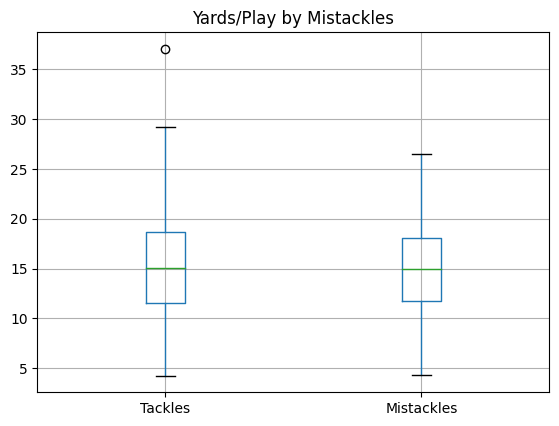

In [54]:
# data = [[avg_result],[avg_mistackle_result]]
# data
avg_abs_diff_tackles.boxplot(column = 'avg_abs_diff',by='mistackles')
plt.title( 'Yards/Play by Mistackles' )
plt.suptitle('')
plt.xlabel('')
plt.xticks([1,2], ['Tackles', 'Mistackles'])
plt.savefig('./mistackles_avg_result.png')

# Yards to go

Yards to go was an important feature so it would be interesting to see if there is any correlation between yeards to go and PA MAD.

In [228]:
yds_to_go = plays[['gameId',	'playId', 'yardsToGo']]
yds_to_go['gameId'] = plays['gameId'].astype(int)
yds_to_go['playId'] = plays['playId'].astype(int)

<ipython-input-228-56dc5be78678>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yds_to_go['gameId'] = plays['gameId'].astype(int)
<ipython-input-228-56dc5be78678>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yds_to_go['playId'] = plays['playId'].astype(int)


In [229]:
play_avg_pa = results.groupby(['gameId','playId','nflId']).agg({'pursuit_angle': 'mean'}).withColumnRenamed("avg(pursuit_angle)", 'avg_pa').toPandas()
play_avg_pa['playId'] = play_avg_abs_diff['playId'].astype(int)
play_avg_pa['gameId'] = play_avg_abs_diff['gameId'].astype(int)

In [230]:
play_avg_pa = play_avg_pa.merge(yds_to_go,on=['gameId','playId'],how='left')

In [231]:
play_avg_pa.head()

,gameId,playId,nflId,avg_pa,yardsToGo
0,2.022103e+09,3785.0,43362,62.235294,10.0
1,2.022103e+09,1570.0,42474,80.133333,3.0
2,2.022103e+09,4353.0,38557,21.428571,5.0
3,2.022103e+09,3116.0,37079,1.161290,6.0
4,2.022103e+09,3135.0,45268,20.211111,10.0
